## Script LQG

********************
%*    Script LQG    *
%********************

Direct translation to python

% Define the linear state-space representation of the system:
%
% x[k+1] = Ax[k] + Bu[k] + xi[k]
%

%-------------------------------------------------------------------------


# Single joint reaching movement

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
G = 0.14
I = 0.1
tau = 0.06

In [9]:
A = np.array([[0, 1, 0],[0, -G/I, 1/I],[0, 0, -1/tau]])
B = np.array([[0],[0],[1/tau]])

In [10]:
ns= np.size(A,0)
nc= np.size(B,1)

In [11]:
#Transformation into discrete time system: Choose a numerical integration
delta = 0.01
A = np.eye(ns)+delta*A
B = delta*B

In [12]:
#Augment the system to include a target state:
A = np.vstack((np.hstack([A,np.zeros((ns,ns))]),np.hstack([np.zeros((ns,ns)),np.eye(ns)])))
B = np.vstack((B,np.zeros((ns,nc))))

# Define the cost-function

% J(x,u) = sum x[k+1]Q[k+1]x[k+1] + u[k]R[k]u[k]

In [13]:
rtime = 0.5
nStep = int(rtime/delta)

In [14]:
Q = np.zeros(((2*ns,2*ns,nStep+1)))
R = np.power(10,-5*np.ones(((nc,nc,nStep))))

In [15]:
# Fill in the cost of the last target
In = np.eye(ns)
w = np.array([1, 1, 0])
for i in np.arange(ns):
    ei = np.vstack((In[:,[i]], -In[:,[i]]))
    Q[:,:,-1] = Q[:,:,-1] + w[i]*ei @ (ei.T)

# Backwards recurrence for the optimal feedback gains

In [16]:
S= Q
oXi = 0.2 *B.dot(B.T)
L = np.zeros(((nc, 2*ns, nStep)))
s=0;

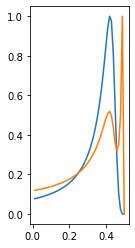

In [21]:
for k in np.arange(nStep-1,-1,-1):
    L[:,:,k] = (B.T @ S[:,:,k+1] @ A ) / (R[:,:,k] + B.T @ S[:,:,k+1] @ B)
    S[:,:,k] = Q[:,:,k] + ( A.T @ S[:,:,k+1] @ (A-(B @ L[:,:,k])))
    s= s + np.trace(S[:,:,k+1]+oXi)

gain = np.zeros((2,nStep))

for k in range(nStep):
    gain[0,k] = L[0,0,k]
    gain[1,k] = L[0,1,k]
    
gain2 = np.zeros((2,nStep))
gain2[0,:] = gain[0,:]/np.ndarray.max(gain[0,:])
gain2[1,:] = gain[1,:]/np.ndarray.max(gain[1,:])
plt.subplot(131)
plt.plot(np.arange(0.01,(nStep+1)*0.01,0.01), gain2[0,0:100])
plt.plot(np.arange(0.01,(nStep+1)*0.01,0.01), gain2[1,0:100])

## forward recurrence for the optimal kalman gain

In [22]:
H      = np.eye(2*ns)
ny     = np.size(H,0)
oOmega = 0.5*np.ndarray.max(oXi)*np.eye(2*ns)
Sigma  = oOmega
K      = np.zeros((2*ns,ny,nStep))

for k in range(nStep):
    K[:,:,k] = (A @ Sigma @ H.T) @ (np.linalg.inv (H @ Sigma @ H.T + oOmega))
    Sigma = oXi + (A-K[:,:,k]@ H) @ (Sigma @ A.T)

# Simulations

<ipython-input-23-30fb7797abf4>:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
<ipython-input-23-30fb7797abf4>:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(133)
<ipython-input-23-30fb7797abf4>:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and return

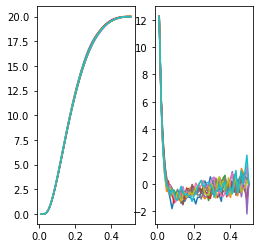

In [23]:
nsimu     = 10
x         = np.zeros(((2*ns,nStep+1,nsimu)))
xhat      = x
control   = np.zeros(((nc,nStep,nsimu)))
avControl = np.zeros((nc,nStep))



#range(nsimu):
for p in range(nsimu):
    x[ns:,0,p] = np.array([20*np.pi/180,0,0])
    
    for k in range(nStep):
        motorNoise   = np.random.multivariate_normal(np.zeros(2*ns),oXi)
        sensorynoise = np.random.multivariate_normal(np.zeros(2*ns),oOmega)
        u              = -L[:,:,k] @ x[:,k,p]
        y              = (H @ x[:,k,p] )+ sensorynoise
        xhat[:,k+1,p]  = (A @ xhat[:,k,p]) + (B @ u) + (K[:,:,k] @ (y- (H @ xhat[:,k,p])))
        x[:,k+1,p]     = (A @ x[:,k,p]) + (B @ u) + motorNoise
        control[:,k,p] = u
        #plt.subplot(132)
        #plt.plot(k*0.01, x[0,k,p]*180/np.pi)
        #plt.pause(0.05)

    avControl = avControl +control[:,:,p]/nsimu
    plt.subplot(132)
    plt.plot(np.arange(0.01,(nStep+2)*0.01,0.01), x[0,:,p]*180/np.pi)
    plt.subplot(133)
    plt.plot(np.arange(0.01,(nStep+1)*0.01,0.01), control[0,:,p])